In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=2f90aea74617545e90b5a769d89054ed37e50388c765b24048d47e1412998288
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from os import listdir
from sklearn.utils import shuffle #shuffling the data improves the model
import imutils  
import itertools
import plotly.graph_objs as go
from sklearn import svm, metrics, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score
from tqdm import tqdm
import os

In [3]:
image_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection'

In [4]:
os.makedirs('/kaggle/working/augmented-images', exist_ok = True)
os.makedirs('/kaggle/working/augmented-images/yes',exist_ok = True)
os.makedirs('/kaggle/working/augmented-images/no', exist_ok = True)

augmented_data_path ='/kaggle/working/augmented-images/'


augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_SIZE = (240, 240)


In [5]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
print(len('/kaggle/working/augmented-images/no'))
print(len('/kaggle/working/augmented-images/yes'))


35
36


In [7]:
dir = os.listdir('/kaggle/working/augmented-images/yes')


if len(dir) == 0: 

    # augment data for the examples with label equal to 'yes' representing tumurous examples
    augment_data(file_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes',n_generated_samples=6, save_to_dir=augmented_data_path+'/yes')
    # augment data for the examples with label equal to 'no' representing non-tumurous examples
    augment_data(file_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection/no', n_generated_samples=9, save_to_dir=augmented_data_path+'/no')
else:
    print(len(dir))

In [8]:
def load_data(dir_list):

    # load all images in a directory
    X = []
    y = []
#     image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
#             image = crop_brain_contour(image, plot=False)
#             image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
#             # normalize values
#             image = image / 255.
#             # convert image to numpy array and append it to X
            X.append(image)
     # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [9]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [10]:
X_train, y_train = load_data([augmented_yes, augmented_no])

Number of examples is: 2064
X shape is: (2064,)
y shape is: (2064, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



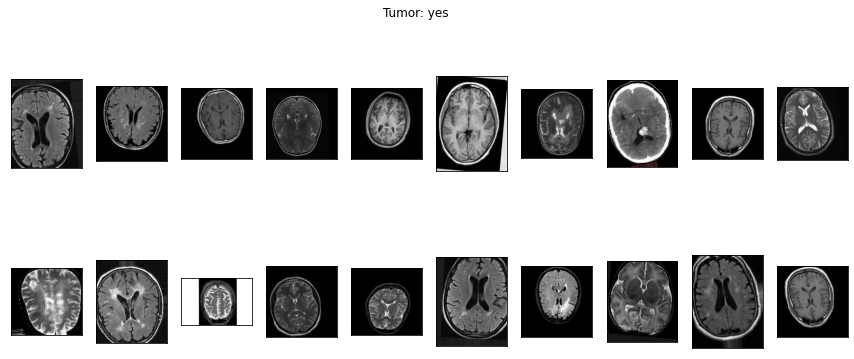

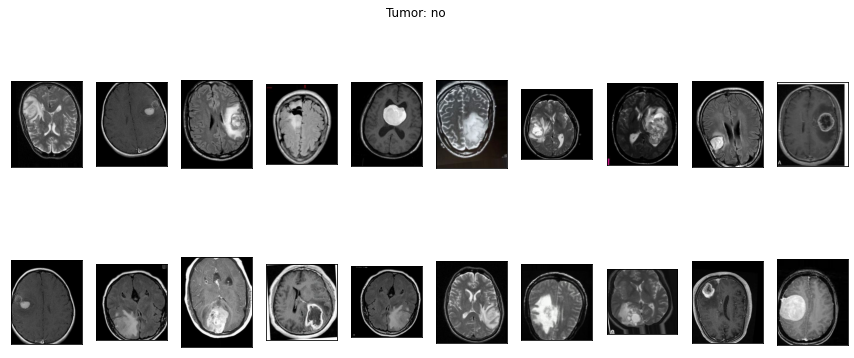

In [11]:
plot_samples(X_train, y_train, ['yes','no'], 20)

# Processing the Data

In [12]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Canny Edge Detection Algortihm from OpenCV
    thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        new_image = image[y:y+h, x:x+w]
        break        

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

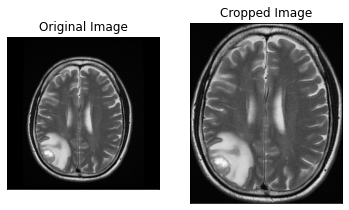

In [13]:
ex_img = cv2.imread(image_dir+'/yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [14]:
def Croping_Data(train):

    # load all images in a directory
    X = []
    y = []
    
    for img in train:
        image = crop_brain_contour(img, plot=False)
        X.append(image)
                
    X = np.array(X)
    
    return X

In [15]:
X = Croping_Data(X_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



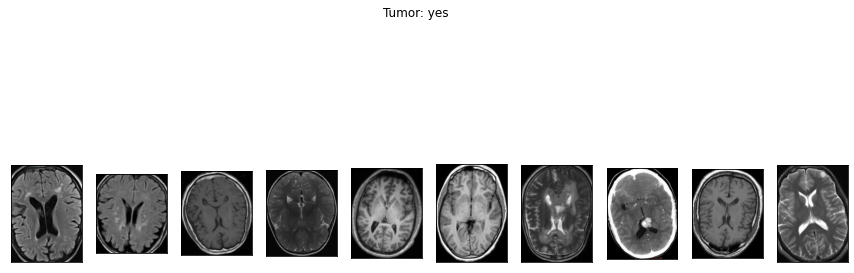

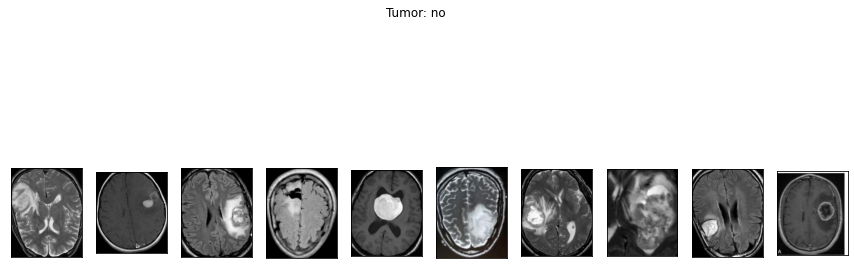

In [16]:
plot_samples(X, y_train, ['yes','no'], 10)

In [17]:
def Resize_Data(train):

    # load all images in a directory
    X = []
    y = []
    
    IMG_WIDTH, IMG_HEIGHT = (240, 240)
    
    for img in train:
        image = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        # normalize values
        image = image / 255.
        # convert image to numpy array and append it to X
        X.append(image)
                
    X = np.array(X)
    
    return X

In [18]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X = Resize_Data(X)
y = y_train

In [19]:
#plot_samples(X, y_train, ['yes','no'],10)

# Data Visualization

In [20]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [22]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

number of training examples = 1444
number of validation examples = 310
number of test examples = 310
Training data and target sizes: 
(1444, 240, 240, 3), (1444, 1)
Test data and target sizes: 
(310, 240, 240, 3), (310, 1)


In [23]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='blue'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [24]:
X_train = X_train.reshape(X_train.shape[0], 172800)
y_train = y_train.reshape(y_train.shape[0], )
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
X_val = X_val.reshape(X_val.shape[0], 172800)
y_val = y_val.reshape(y_val.shape[0], )
X_test = X_test.reshape(X_test.shape[0], 172800)
y_test = y_test.reshape(y_test.shape[0], )
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(1444, 172800), (1444,)
Test data and target sizes: 
(310, 172800), (310,)


**SVM model**

In [25]:
# Create a classifier: a support vector classifier
param_grid = [
  {'C': [1, 10], 'kernel': ['linear']},
 ]
svc = svm.SVC()
classifier = GridSearchCV(svc, param_grid, verbose = 3)
classifier.fit(X_train, y_train)
#fit to the training data

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.678 total time= 2.1min
[CV 2/5] END ................C=1, kernel=linear;, score=0.706 total time= 2.2min
[CV 3/5] END ................C=1, kernel=linear;, score=0.747 total time= 2.2min
[CV 4/5] END ................C=1, kernel=linear;, score=0.689 total time= 2.1min
[CV 5/5] END ................C=1, kernel=linear;, score=0.684 total time= 2.1min
[CV 1/5] END ...............C=10, kernel=linear;, score=0.678 total time= 2.1min
[CV 2/5] END ...............C=10, kernel=linear;, score=0.706 total time= 2.2min
[CV 3/5] END ...............C=10, kernel=linear;, score=0.747 total time= 2.1min
[CV 4/5] END ...............C=10, kernel=linear;, score=0.689 total time= 2.1min
[CV 5/5] END ...............C=10, kernel=linear;, score=0.684 total time= 2.1min


GridSearchCV(estimator=SVC(), param_grid=[{'C': [1, 10], 'kernel': ['linear']}],
             verbose=3)

Model Predections

In [26]:
y_pred = classifier.predict(X_test)

In [27]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, y_pred)))

Classification report for classifier GridSearchCV(estimator=SVC(), param_grid=[{'C': [1, 10], 'kernel': ['linear']}],
             verbose=3):
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       137
           1       0.80      0.74      0.77       173

    accuracy                           0.75       310
   macro avg       0.75      0.75      0.75       310
weighted avg       0.75      0.75      0.75       310




In [28]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

Confusion matrix:
[[104  33]
 [ 45 128]]


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Val Accuracy = 0.71


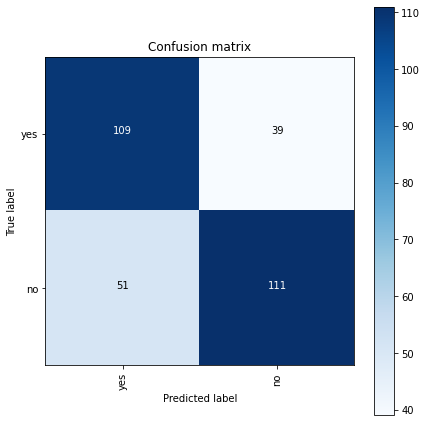

In [30]:
labels = ['yes','no']
# validate on val set
predictions = classifier.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)


Test Accuracy = 0.75


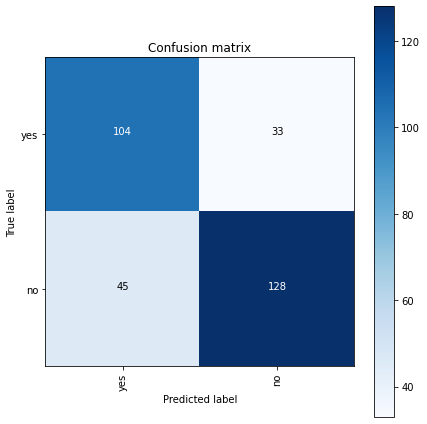

In [31]:
# validate on test set
predictions = classifier.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)